In [1]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from scipy.optimize import minimize

import importlib

import src.src_qubit_oscillations
importlib.reload(src.src_qubit_oscillations)

from src.src_qubit_oscillations import (
    QubitOscillationMeasurement,
    generate_oscillation_filename,
    create_annihilation_operators,
    create_number_operators,
    create_collapse_operators,
    calculate_population_simulation,
    fit_to_data,
)

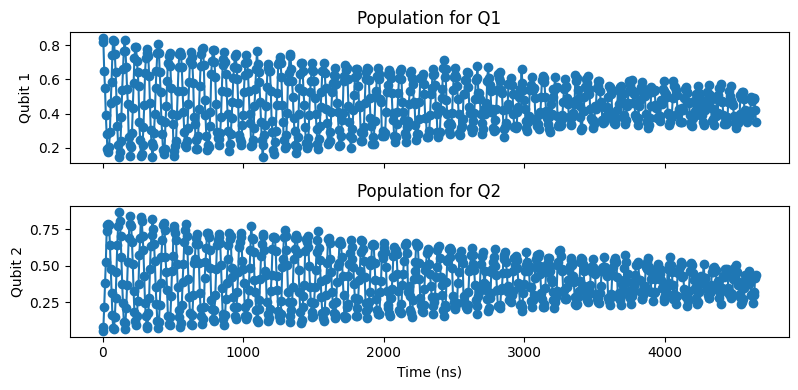

In [2]:
import src.src_qubit_oscillations
importlib.reload(src.src_qubit_oscillations)

from src.src_qubit_oscillations import QubitOscillationMeasurement, generate_oscillation_filename

filename = generate_oscillation_filename('2025', '09', '22', '10', '56', '28')

measurement = QubitOscillationMeasurement(filename)
measurement.acquire_data()

measurement.plot_populations()

In [3]:
import src.src_qubit_oscillations
importlib.reload(src.src_qubit_oscillations)

from src.src_qubit_oscillations import QubitOscillationMeasurement, generate_oscillation_filename, generate_triangle_lattice_Hamiltonian


filename_dict = {}
filename_dict['2Q_long'] = generate_oscillation_filename('2025', '09', '22', '10', '56', '28')
filename_dict['4Q_long'] = generate_oscillation_filename('2025', '09', '22', '11', '21', '53')
filename_dict['8Q_long'] = generate_oscillation_filename('2025', '09', '22', '11', '53', '12')
filename_dict['67_long'] = generate_oscillation_filename('2025', '09', '24', '11', '18', '39')

measurement_dict = {}
for name in filename_dict:
    measurement = QubitOscillationMeasurement(filename_dict[name])
    measurement_dict[name] = measurement

2Q_long
4Q_long
8Q_long
67_long


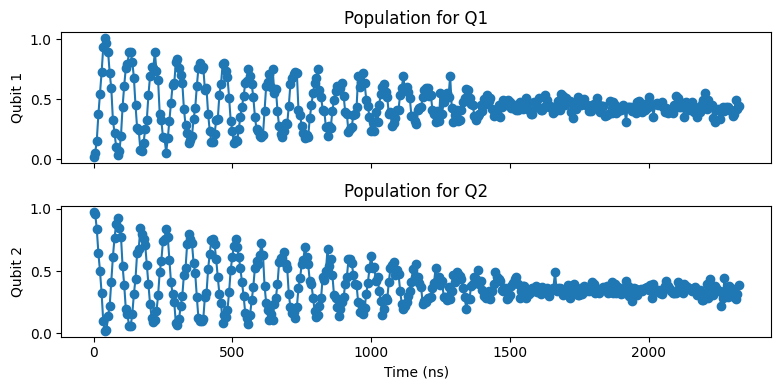

In [5]:
plot_names = None
plot_names = ['67_long']

for name in measurement_dict:
    print(name)
    if plot_names is None or name in plot_names:
        measurement_dict[name].plot_populations(corrected=True)

# 1. 2 Qubits

In [ ]:
num_levels = 2
num_qubits = 2

measurement = measurement_dict['2Q_long']
measurement = measurement_dict['67_long']


population_data = measurement.get_population(corrected=True)
times = measurement.get_times()
times_us = times * 1e-3

In [30]:
J = 6.39 * 2 * np.pi
J_parallel = J

T1s = [20, 10]  # in us
T2s = [1,1]  # in us

U = -180 * 2 * np.pi


psi0 = qt.basis([num_levels]*num_qubits, [1, 0])  # Initial state |10>

annihilation_operators = create_annihilation_operators(num_levels, num_qubits)  
number_operators = create_number_operators(annihilation_operators)
collapse_operators = create_collapse_operators(annihilation_operators, T1s, T2s)


H = generate_triangle_lattice_Hamiltonian(annihilation_operators, J, J_parallel, U)

result = qt.mesolve(H, psi0, times_us, c_ops=collapse_operators)

population_simulation = np.zeros((num_qubits, len(times)))
for i in range(num_qubits):
    for j in range(len(result.states)):
        population_simulation[i][j] = qt.expect(number_operators[i], result.states[j])

cost = np.sum((population_data - population_simulation)**2)
print(f'cost: {cost}')

cost: 44.013509212755324


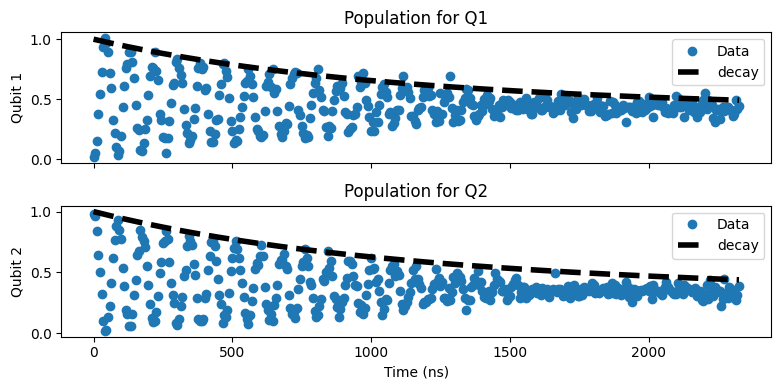

In [32]:
fig, axes = plt.subplots(population_data.shape[0], 1, figsize=(8, 2 * population_data.shape[0]), sharex=True)

for i in range(population_data.shape[0]):
    axes[i].plot(times, population_data[i, :], 'o', label='Data')
    # axes[i].plot(times, population_simulation[i, :], label='Simulation')

    axes[i].plot(times, 1/2*np.exp(-times_us/T1s[i]) + 0.5*np.exp(-times_us*(1/(2*T1s[i]) + 1/T2s[i])), '--', linewidth=4, label='decay', color='black')

    axes[i].set_ylabel(f'Qubit {i+1}')
    axes[i].set_title(f'Population for Q{i+1}')

    axes[i].legend()

axes[-1].set_xlabel('Time (ns)')
# plt.xlim(0, 100)

plt.tight_layout()
plt.show()


In [17]:
def objective_function(x):
    J = x[0]
    T1s = x[1:3]
    T2s = x[3:5]

    collapse_operators = create_collapse_operators(annihilation_operators, T1s, T2s)
    H = generate_triangle_lattice_Hamiltonian(annihilation_operators, J, J_parallel, U)
    result = qt.mesolve(H, psi0, times_us, e_ops=number_operators, c_ops=collapse_operators)

    populations_fit = result.expect

    return np.sum(np.power(populations_fit - population_data, 2))
    

In [18]:
initial_guess = [J] + T1s + T2s

bounds = [(0, 10 * 2 * np.pi)] + [(0.1, 100)]*2 + [(0.1, 50)]*2

optimize_result = minimize(objective_function, x0=initial_guess, method='Nelder-Mead', options={'maxiter': 50, 'disp': True}, bounds=bounds)

J_opt = optimize_result.x[0]
T1s_opt = np.array(optimize_result.x[1:3])
T2s_opt = np.array(optimize_result.x[3:5])

print(f'Optimized J: {J_opt/(2*np.pi):.2f} MHz')
print(f'Optimized T1s: {T1s_opt} us')
print(f'Optimized T2s: {T2s_opt} us')

Optimized J: 6.80 MHz
Optimized T1s: [58.91828152 25.72146507] us
Optimized T2s: [0.1        3.71671108] us


C:\Users\mattm\AppData\Local\Temp\ipykernel_25512\2044732780.py:5: RuntimeWarning: Maximum number of iterations has been exceeded.
  optimize_result = minimize(objective_function, x0=initial_guess, method='Nelder-Mead', options={'maxiter': 50, 'disp': True}, bounds=bounds)


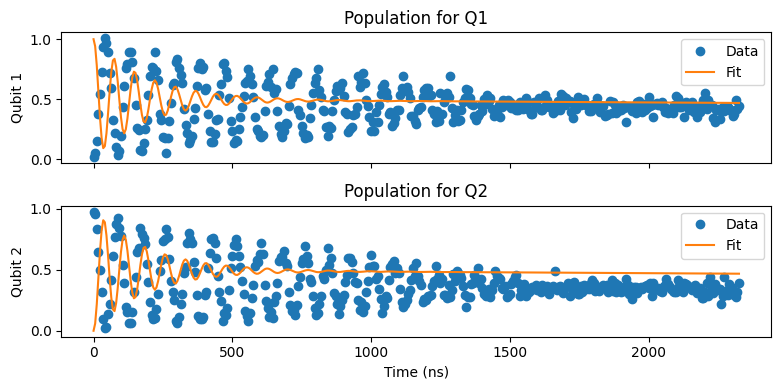

In [19]:

H = generate_triangle_lattice_Hamiltonian(annihilation_operators, J_opt, J_opt, U)

collapse_operators = create_collapse_operators(annihilation_operators, T1s_opt, T2s_opt)

result = qt.mesolve(H, psi0, times_us, c_ops=collapse_operators)

population_fit = np.zeros((num_qubits, len(times)))
for i in range(num_qubits):
    for j in range(len(result.states)):
        population_fit[i][j] = qt.expect(number_operators[i], result.states[j])

fig, axes = plt.subplots(population_data.shape[0], 1, figsize=(8, 2 * population_data.shape[0]), sharex=True)

for i in range(population_data.shape[0]):
    axes[i].plot(times, population_data[i, :], 'o', label='Data')
    axes[i].plot(times, population_fit[i, :], label='Fit')
    axes[i].legend()

    axes[i].set_ylabel(f'Qubit {i+1}')
    axes[i].set_title(f'Population for Q{i+1}')

axes[-1].set_xlabel('Time (ns)')

plt.tight_layout()
plt.show()


# 2. 4 Qubits

In [473]:
num_levels = 2
num_qubits = 4

measurement = measurement_dict['4Q_long']


population_data = measurement.get_population(corrected=True)
times = measurement.get_times()
times_us = times * 1e-3

In [474]:
J = -np.array([6.4, 7, 6.39]) * 2 * np.pi
J_parallel = -np.array([6.39, 5.6]) * 2 * np.pi

T1s = [100, 50, 50, 50]  # in us

T2s = [10, 2, 1, 2]  # in us

U = -180 * 2 * np.pi

detunings = np.array([0, 0, 0, 0]) * 2 * np.pi
detunings = np.array([1, 0, 0, 1]) * 2 * np.pi


######


######


psi0 = qt.basis([num_levels]*num_qubits, [0, 1, 0, 0])  # Initial state |10>

annihilation_operators = create_annihilation_operators(num_levels, num_qubits)  
number_operators = create_number_operators(annihilation_operators)
collapse_operators = create_collapse_operators(annihilation_operators, T1s, T2s)


H = generate_triangle_lattice_Hamiltonian(annihilation_operators, J, J_parallel, U)

result = qt.mesolve(H, psi0, times_us, c_ops=collapse_operators)



population_simulation = np.zeros((num_qubits, len(times)))
for i in range(num_qubits):
    for j in range(len(result.states)):
        population_simulation[i][j] = qt.expect(number_operators[i], result.states[j])

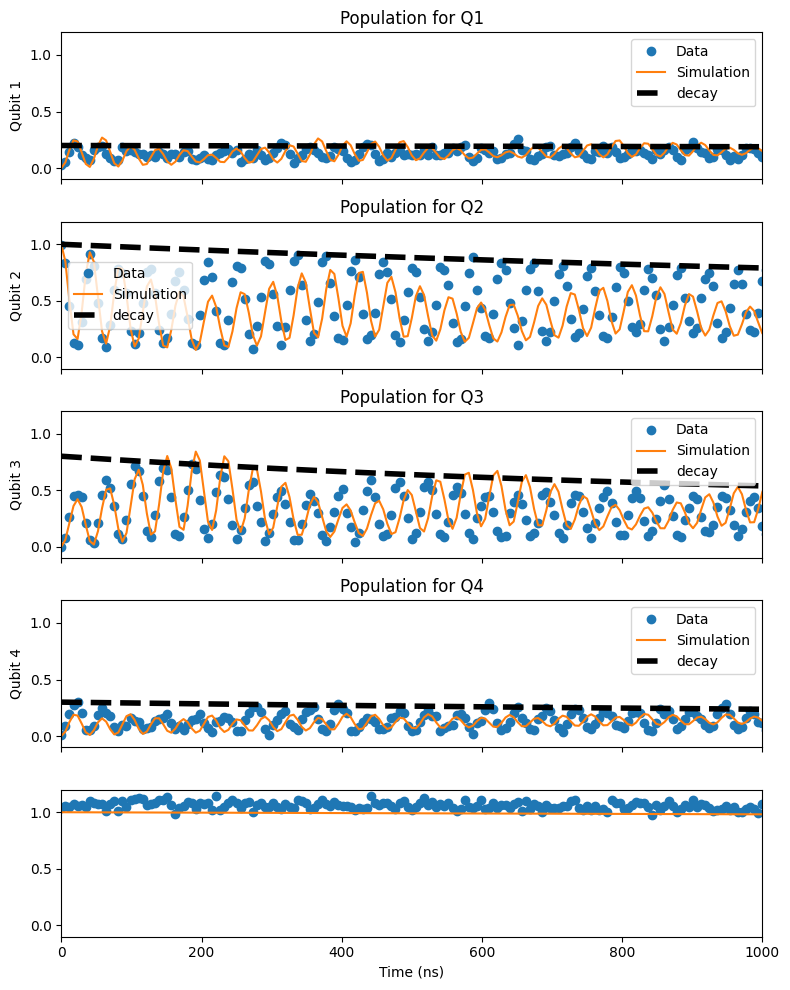

In [475]:
plot_sum = True

num_axes = population_data.shape[0]
if plot_sum:
    num_axes += 1

fig, axes = plt.subplots(num_axes, 1, figsize=(8, 2 * num_axes), sharex=True)

amps = [0.2, 1, 0.8, 0.3]

for i in range(population_data.shape[0]):
    axes[i].plot(times, population_data[i, :], 'o', label='Data')
    axes[i].plot(times, population_simulation[i, :], label='Simulation')

   
    axes[i].plot(times, amps[i]/2*(np.exp(-times_us/T1s[i]) + np.exp(-times_us*(1/(2*T1s[i]) + 1/T2s[i]))), '--', linewidth=4, label='decay', color='black')

    axes[i].set_xlim(0, 1000)
    axes[i].set_ylim(-0.1, 1.2)

    axes[i].set_ylabel(f'Qubit {i+1}')
    axes[i].set_title(f'Population for Q{i+1}')


    axes[i].legend()



if plot_sum:
    axes[-1].plot(times, np.sum(population_data, axis=0), 'o', label='Data Sum')
    axes[-1].plot(times, np.sum(population_simulation, axis=0), label='Simulation Sum')
    axes[-1].set_ylim(-0.1, 1.2)

axes[-1].set_xlabel('Time (ns)')

plt.tight_layout()
plt.show()


In [478]:

simulation_kwargs = dict(
    annihilation_operators=annihilation_operators,
    number_operators=number_operators,
    num_levels=num_levels,
    num_qubits=num_qubits,
    J=J,
    J_parallel=J_parallel,
    U=U,
    T1s=T1s,
    T2s=T2s,
    times=times_us,
    detunings=detunings,
    psi0=psi0,
)


initial_cost = np.sum(np.power((population_data, calculate_population_simulation(**simulation_kwargs)), 2))
print(f'initial cost: {initial_cost:.4f}')


fit_params = ['J', 'J_parallel', 'detunings', 'T1s', 'T2s']
fit_params = ['J', 'J_parallel', 'detunings']


result = fit_to_data(simulation_kwargs, population_data, fit_params, calculate_population_simulation)

initial cost: 501.1668
simulation_kwargs keys: dict_keys(['annihilation_operators', 'number_operators', 'num_levels', 'num_qubits', 'J', 'J_parallel', 'U', 'T1s', 'T2s', 'times', 'detunings', 'psi0'])
fit params: ['J', 'J_parallel', 'detunings']
<function fit_to_data.<locals>.create_objective_function.<locals>.objective_function at 0x000001E9EA0FB910>
Key to Indices: {'J': (0, 3), 'J_parallel': (3, 5), 'detunings': (5, 9)}
Initial Guess: [-40.21238596594935, -43.982297150257104, -40.14955411287755, -40.14955411287755, -35.18583772020568, 6.283185307179586, 0.0, 0.0, 6.283185307179586]
Bounds: [(-72.38229473870884, -8.042477193189868), (-79.16813487046278, -8.79645943005142), (-72.26919740317959, -8.02991082257551), (-72.26919740317959, -8.02991082257551), (-63.334507896370226, -7.037167544041136), (-50.26548245743669, 50.26548245743669), (-50.26548245743669, 50.26548245743669), (-50.26548245743669, 50.26548245743669), (-50.26548245743669, 50.26548245743669)]
Optimization success: False

# 3. 8 Qubits

In [440]:
num_levels = 2
num_qubits = 8

measurement = measurement_dict['8Q_long']


population_data = measurement.get_population(corrected=True)
times = measurement.get_times()
times_us = times * 1e-3

In [441]:
J = -np.array([6.39]*(num_qubits-1)) * 2 * np.pi
J_parallel = -np.array([6.39]*(num_qubits-2)) * 2 * np.pi

T1s = [50, 50, 50, 50, 50, 50, 50, 50]  # in us

T2s = [1, 1, 1, 1, 1, 1, 1, 1]  # in us
T2s = [2, 2, 2, 2, 2, 2, 2, 2]  # in us

U = -180 * 2 * np.pi

detunings = np.array([0]*8) * 2 * np.pi


psi0 = qt.basis([num_levels]*num_qubits, [0, 0, 0, 0, 0, 0, 0, 1])  # Initial state |10>

annihilation_operators = create_annihilation_operators(num_levels, num_qubits)  
number_operators = create_number_operators(annihilation_operators)
collapse_operators = create_collapse_operators(annihilation_operators, T1s, T2s)


H = generate_triangle_lattice_Hamiltonian(annihilation_operators, J, J_parallel, U)

result = qt.mesolve(H, psi0, times_us, c_ops=collapse_operators)



population_simulation = np.zeros((num_qubits, len(times)))
for i in range(num_qubits):
    for j in range(len(result.states)):
        population_simulation[i][j] = qt.expect(number_operators[i], result.states[j])

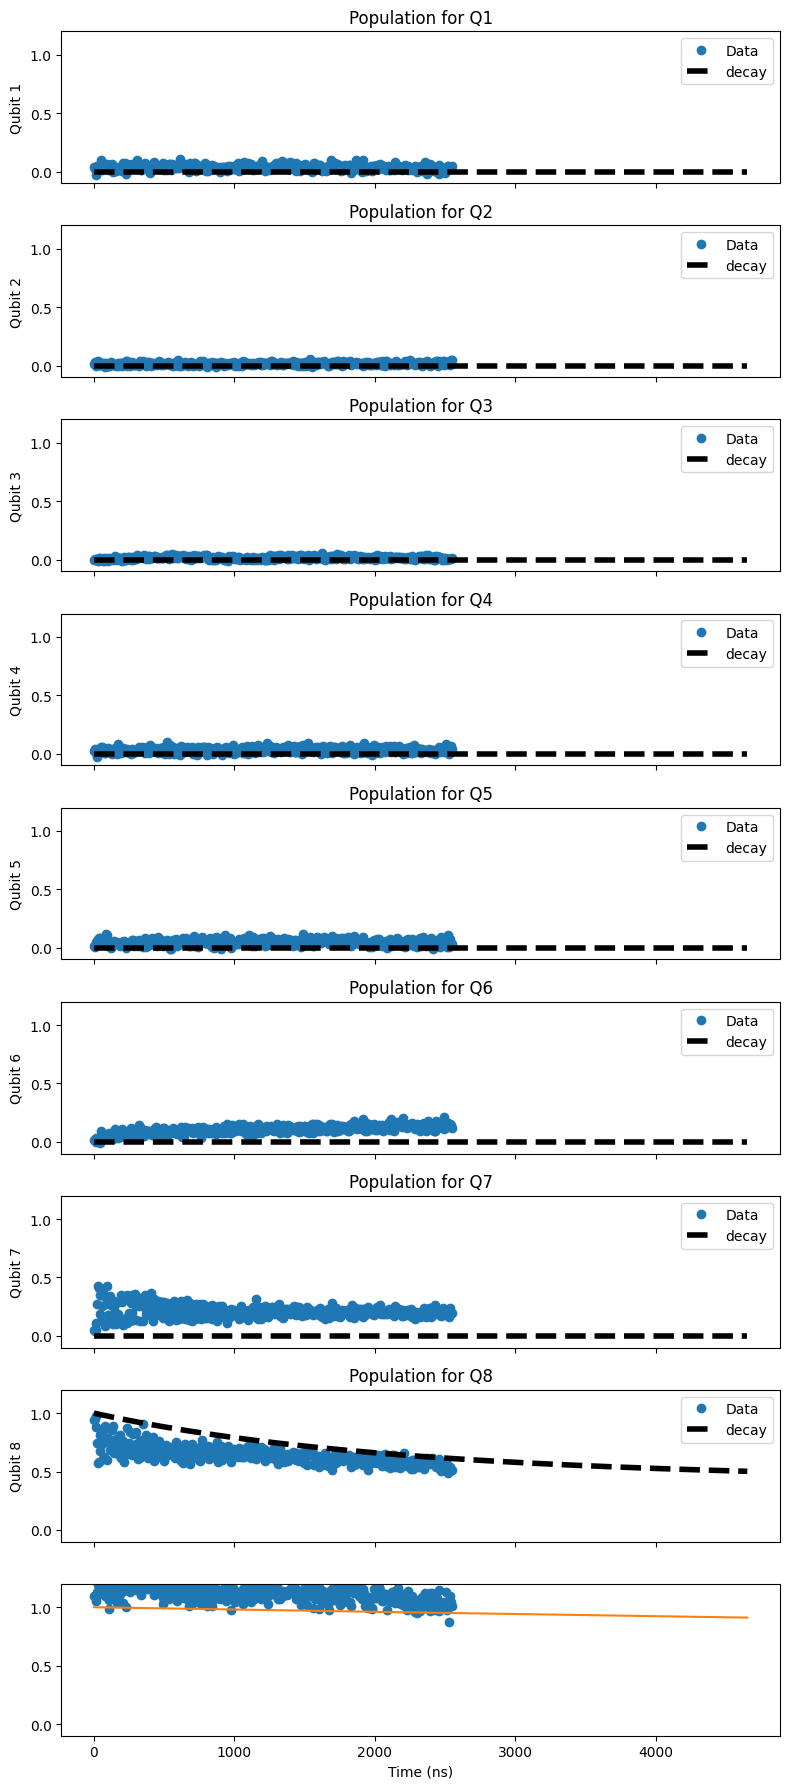

In [442]:
plot_sum = True

num_axes = population_data.shape[0]
if plot_sum:
    num_axes += 1

fig, axes = plt.subplots(num_axes, 1, figsize=(8, 2 * num_axes), sharex=True)

amps = [0, 0, 0, 0, 0, 0, 0, 1]

for i in range(population_data.shape[0]):
    axes[i].plot(times, population_data[i, :], 'o', label='Data')
    # axes[i].plot(times, population_simulation[i, :], label='Simulation')

   
    axes[i].plot(times, amps[i]/2*(np.exp(-times_us/T1s[i]) + np.exp(-times_us*(1/(2*T1s[i]) + 1/T2s[i]))), '--', linewidth=4, label='decay', color='black')

    # axes[i].set_xlim(0, 500)
    axes[i].set_ylim(-0.1, 1.2)

    axes[i].set_ylabel(f'Qubit {i+1}')
    axes[i].set_title(f'Population for Q{i+1}')


    axes[i].legend()



if plot_sum:
    axes[-1].plot(times, np.sum(population_data, axis=0), 'o', label='Data Sum')
    axes[-1].plot(times, np.sum(population_simulation, axis=0), label='Simulation Sum')
    axes[-1].set_ylim(-0.1, 1.2)

axes[-1].set_xlabel('Time (ns)')

plt.tight_layout()
plt.show()
